In [ ]:
!nvidia-smi

Sat Jun 11 04:04:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [2]:
# Cifar-10 data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [3]:
# Data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2) #ori num_workers=2
testLoader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2) #ori num_workers=2

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Data classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# show image function
import matplotlib.pyplot as plt
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

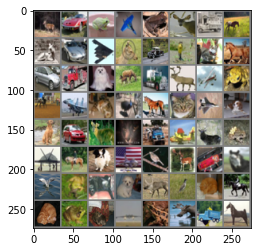

In [6]:
# show train images dataset
dataiter = iter(trainLoader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [7]:
# Model structure
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(1024, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
# GPU
net = Net().cuda()
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 

In [9]:
# Parameters
criterion = nn.CrossEntropyLoss()
criterion.cuda()
lr = 0.0002
epochs = 25
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

In [10]:
# Train
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    accuracy = 0
    count = 0

    for data in trainLoader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda() # GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy += (predicted == labels).sum().item()
        count += len(inputs)
        running_loss += loss.item() * len(labels)

        loss.backward()
        optimizer.step()

    print('[%2d/%2d] Loss: %.3f  |  Accuracy: %.2f %%' % (epoch+1, epochs, running_loss / count, 100 * accuracy / count))

print('Finished Training')

[ 1/25] Loss: 1.360  |  Accuracy: 50.73 %
[ 2/25] Loss: 0.857  |  Accuracy: 70.34 %
[ 3/25] Loss: 0.662  |  Accuracy: 77.53 %
[ 4/25] Loss: 0.544  |  Accuracy: 81.45 %
[ 5/25] Loss: 0.451  |  Accuracy: 84.70 %
[ 6/25] Loss: 0.376  |  Accuracy: 87.26 %
[ 7/25] Loss: 0.317  |  Accuracy: 89.17 %
[ 8/25] Loss: 0.265  |  Accuracy: 91.03 %
[ 9/25] Loss: 0.220  |  Accuracy: 92.47 %
[10/25] Loss: 0.183  |  Accuracy: 93.72 %
[11/25] Loss: 0.165  |  Accuracy: 94.39 %
[12/25] Loss: 0.140  |  Accuracy: 95.21 %
[13/25] Loss: 0.124  |  Accuracy: 95.76 %
[14/25] Loss: 0.114  |  Accuracy: 96.11 %
[15/25] Loss: 0.100  |  Accuracy: 96.65 %
[16/25] Loss: 0.094  |  Accuracy: 96.79 %
[17/25] Loss: 0.088  |  Accuracy: 97.09 %
[18/25] Loss: 0.084  |  Accuracy: 97.19 %
[19/25] Loss: 0.073  |  Accuracy: 97.58 %
[20/25] Loss: 0.075  |  Accuracy: 97.49 %
[21/25] Loss: 0.069  |  Accuracy: 97.71 %
[22/25] Loss: 0.069  |  Accuracy: 97.66 %
[23/25] Loss: 0.062  |  Accuracy: 97.99 %
[24/25] Loss: 0.065  |  Accuracy: 

In [11]:
# show test images dataset
dataiter = iter(testLoader)

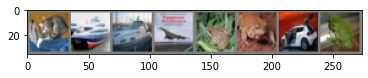

  Answer  :   cat   ship   ship  plane   frog   frog    car   frog
Predicted :   cat   ship   ship  plane   frog   frog    cat   frog


In [12]:
# run this block, can see different images
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("  Answer  :", "  ".join("%5s" % classes[labels[i]] for i in range(8)))

outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)
print("Predicted :", "  ".join("%5s" % classes[predicted[i]] for i in range(8)))

In [13]:
# Test
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += len(inputs)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test inputs: %.2f %%' % (100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test inputs: 83.78 %
Accuracy of plane : 83 %
Accuracy of   car : 88 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 75 %
Accuracy of   dog : 80 %
Accuracy of  frog : 88 %
Accuracy of horse : 86 %
Accuracy of  ship : 92 %
Accuracy of truck : 92 %
